# Modelo de Regresión - v3

XGBRegressor(colsample_bytree = 1.0, learning_rate = 0.035, max_depth = 10, min_child_weight = 1, n_estimators = 100, n_jobs = -1, reg_alpha = 0 ,reg_lambda = 0.5, subsample = 0.8)



## IMPORTACIÓN DE PAQUETES

In [46]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor

#Métricas de evaluación
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Crear Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

import cloudpickle

## IMPORTAR LOS DATOS

### CARGAR LOS DATOS

In [47]:
x = pd.read_pickle('../../02_Datos/03_Trabajo/x_preselecionado.pickle')
y = pd.read_pickle('../../02_Datos/03_Trabajo/y_preselecionado.pickle')

In [48]:
x = x[['distance_station', 'latitude', 'age', 'stores', 'mes']]


In [49]:
x.head(5)

,distance_station,latitude,age,stores,mes
0,84.87882,24.98298,32.0,10,12
1,306.59470,24.98034,19.5,9,12
2,561.98450,24.98746,13.3,5,8
3,561.98450,24.98746,13.3,5,7
4,287.60250,24.98042,20.3,6,6


## MODELIZAR

### CARGAMOS EL MEJOR MODELO CON EL ALGORITMO, PARÁMETROS Y VALORES

In [50]:
modelo = pd.read_pickle('../../04_Modelos/01_Best_estimator/XGBRegressor_v06.pickle')

### EXAMINAR EL MEJOR MODELO

In [51]:
modelo.best_estimator_

Pipeline(steps=[('algoritmo',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=1.0, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.035,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None, min_child_weight=1,
                              missing=nan, monotone_constraints=None,
                              n_estimators=100, n_jobs=-1,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, ...))])

### PREDECIR SOBRE LA VALIDACIÓN

In [52]:
pred = modelo.best_estimator_.predict(x)

### EVALUAR SOBRE LA VALIDACIÓN

In [53]:
print("%mape:", mean_absolute_percentage_error(y, pred))
print("Coeficiente de determinación:", r2_score(y,pred))
print("MAE:", mean_absolute_error(y, pred))
print("RMSE:", mean_squared_error(y,pred,squared='False'))

%mape: 0.06460987440146296
Coeficiente de determinación: 0.9103831347344236
MAE: 2.4981039815478856
RMSE: 15.678968449686298


#### Gráfico entre la diferencia entre la validación y el original

In [54]:
test_y = y.reset_index().copy()
test_pred = pd.Series(pred).to_frame()
df_pred = pd.concat([test_y,test_pred], axis= 1).sort_values(by='price').reset_index()
df_pred.rename(columns = {0:'pred'}, inplace = True)
df_pred = df_pred.drop(columns= ['level_0'])
df_pred['dif'] = abs(df_pred['price']-df_pred['pred'])
# Diferencia entre predicción y validación
df_pred.sort_values(by = 'dif', ascending = False)[:10]

,index,price,pred,dif
105,165,32.4,50.241058,17.841058
68,180,26.5,43.840477,17.340477
176,242,41.2,24.635963,16.564037
281,273,67.7,52.113647,15.586353
276,86,60.7,45.415512,15.284488
230,62,48.0,35.796093,12.203907
264,109,55.5,43.745739,11.754261
278,231,62.1,51.604382,10.495618
259,42,55.0,44.671558,10.328442
221,241,46.6,36.371330,10.228670


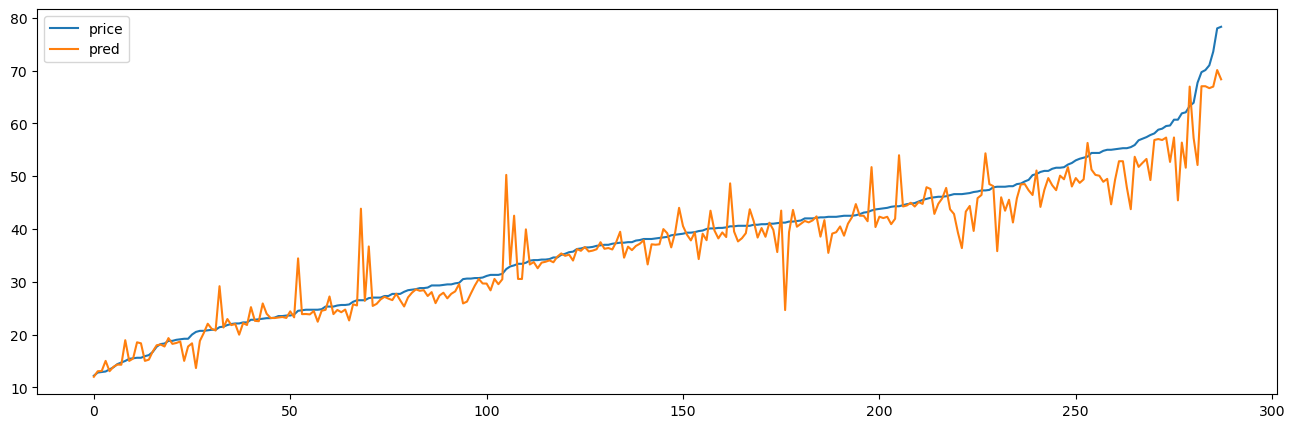

In [55]:
df_pred[['price','pred']].plot(figsize=(16,5));

## Gráficios de validación modelos de regresión

2. Gráfico de residuos vs. valores predichos: 


Un gráfico de residuos muestra los residuos (diferencias entre los valores observados y los valores predichos por el modelo) en función de los valores ajustados o las variables independientes. Este gráfico puede ayudarte a verificar si los residuos tienen algún patrón sistemático, como una relación no lineal o una heterocedasticidad.

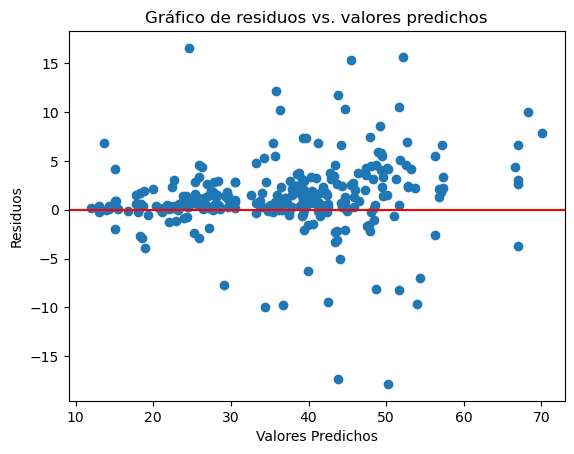

In [56]:
val_y = y
residuos = val_y - pred

plt.scatter(pred, residuos)
plt.axhline(y=0, color='red')  # Línea horizontal en cero
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos vs. valores predichos')
plt.show()


3. Histograma de residuos:

 Este gráfico muestra la distribución de los residuos del modelo. Puedes utilizar un histograma o un gráfico de densidad para visualizar cómo se distribuyen los residuos y verificar si siguen una distribución aproximadamente normal.

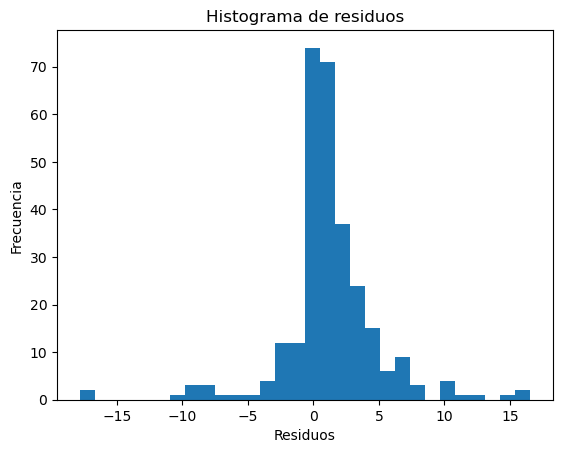

In [57]:
plt.hist(residuos, bins=30)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de residuos')
plt.show()

4. Gráfico de Q-Q (cuantil-cuantil):

Este gráfico compara los cuantiles de los residuos con los cuantiles esperados de una distribución normal. Puede ayudarte a evaluar si los residuos siguen una distribución normal.

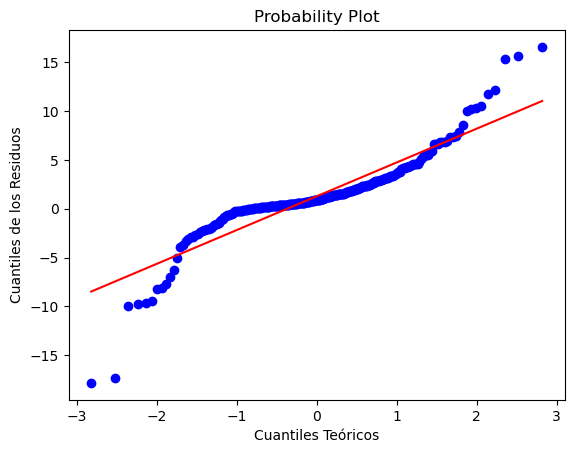

In [58]:
import scipy.stats as stats

stats.probplot(residuos, dist="norm", plot=plt)
plt.xlabel('Cuantiles Teóricos')
plt.ylabel('Cuantiles de los Residuos')
plt.show()


5. Gráfico de influencia:

Un gráfico de influencia muestra la influencia de cada observación en el ajuste del modelo. Puede ayudarte a identificar puntos atípicos o valores influyentes que pueden tener un impacto significativo en los resultados de la regresión.

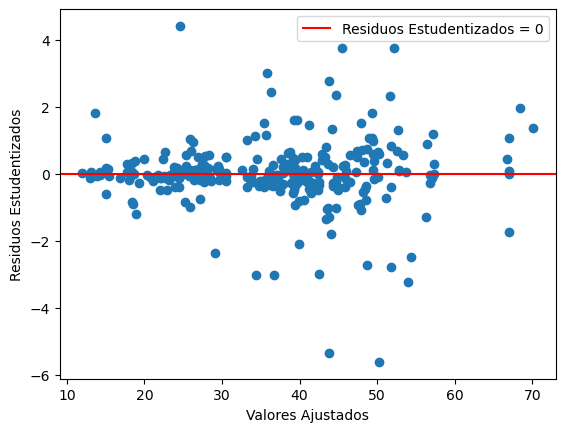

In [59]:
import statsmodels.api as sm

infl = sm.OLS(val_y, sm.add_constant(pred)).fit().get_influence()
residuos_estudentizados = infl.resid_studentized_external

plt.scatter(pred, residuos_estudentizados)
plt.axhline(y=0, color='r', linestyle='-', label='Residuos Estudentizados = 0')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos Estudentizados')
plt.legend()
plt.show()

### CREAR PIPELINE DE ENTRENAMIENTO

### Instanciar el Modelo

In [60]:
XGBRegressor(colsample_bytree = 1.0, learning_rate = 0.035, max_depth = 10, min_child_weight = 1, 
             n_estimators = 100, n_jobs = -1, reg_alpha = 0 ,reg_lambda = 0.5, subsample = 0.8)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.035, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Crear el pipe final de de entrenamiento

In [61]:
pipe_entrenamiento = make_pipeline(modelo)

#### Guardar el pipe final de entrenamiento

In [62]:
nombre_pipe_entrenamiento = 'pipe_entrenamiento_v3.pickle'
ruta_pipe_entrenamiento = '../../04_Modelos/' + nombre_pipe_entrenamiento

with open (ruta_pipe_entrenamiento, mode= 'wb') as file:
    cloudpickle.dump(pipe_entrenamiento, file)


#### Entrenar el pipe final de ejecucción

In [63]:
pipe_ejecucion = pipe_entrenamiento.fit(x,y)

#### Guardar el pipe final de entrenamiento

In [64]:
nombre_pipe_ejecucion = 'pipe_ejecucion_v3.pickle'
ruta_pipe_ejecucion = '../../04_Modelos/' + nombre_pipe_ejecucion

with open (ruta_pipe_ejecucion, mode= 'wb') as file:
    cloudpickle.dump(pipe_ejecucion, file)
